# Assignment 03 
This assignment is a work of a student at KFUPM in a deep learning course "**ICS 471**"
## Student Information
**Name:** Ahmed Badawood
**Student ID:** 201771730

## The Code

### Importing the needed classes

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import os
import matplotlib.pyplot as plt
import numpy as np
import time
import random

import warnings
warnings.filterwarnings("ignore")

In [2]:
os.listdir("HW4_Data/classification_data")

['test_data', 'train_data', 'val_data']

In [3]:
root = "HW4_Data/classification_data/"

trn_pth = root + "train_data"
val_pth = root + "val_data"
tst_pth = root + "test_data"

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [5]:
train_dataset = datasets.ImageFolder(root = trn_pth, transform=train_transforms)

In [6]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=64, shuffle=False)

In [7]:
def cal_mean_std(loader):
    mean     = 0.0
    std      = 0.0
    n_images = 0
    
    for images, _ in loader:
        n_img_batch = images.size(0)
        images = images.view(n_img_batch, images.size(1), -1)
        
        mean     += images.mean(2).sum(0)
        std      += images.std(2).sum(0)
        n_images += n_img_batch
    
    mean /= n_images
    std  /= n_images
    
    return mean, std

In [8]:
mean, std = cal_mean_std(train_loader)

In [9]:
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: tensor([0.5025, 0.4218, 0.3816])
Calculated std: tensor([0.2588, 0.2382, 0.2309])


In [10]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(64, padding = 2),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

val_transforms  = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transforms  = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [11]:
train_data = datasets.ImageFolder(root = trn_pth, transform=train_transforms)
val_data   = datasets.ImageFolder(root = val_pth, transform=val_transforms)
test_data  = datasets.ImageFolder(root = tst_pth, transform=test_transforms)

In [12]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(val_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 790
Number of validation examples: 20
Number of testing examples: 20


In [13]:
def show_imgs(dataset):
    loader = data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([7, 2, 9, 2, 4, 7])


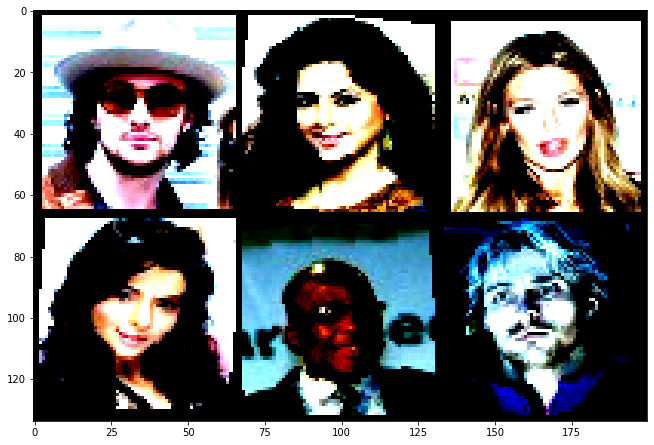

In [14]:
show_imgs(train_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([1, 1, 5, 4, 4, 9])


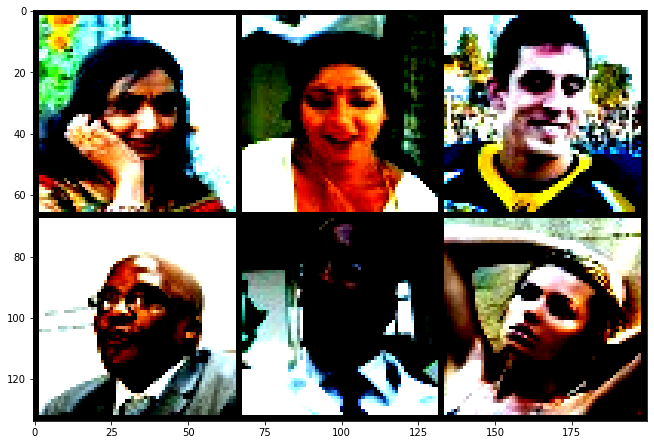

In [15]:
show_imgs(val_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([0, 2, 0, 4, 9, 5])


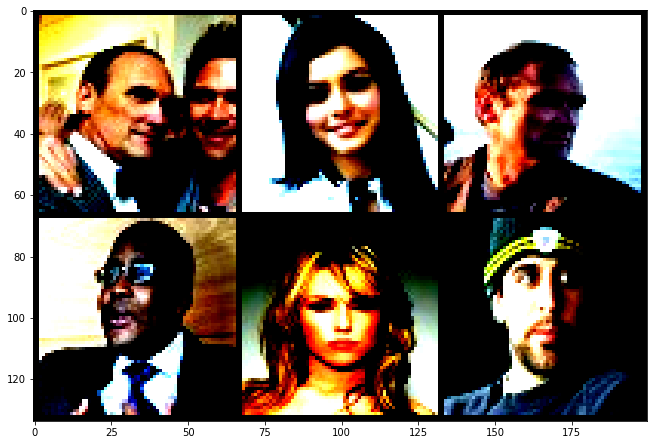

In [16]:
show_imgs(test_data)

In [17]:
same_classes = train_data.classes == val_data.classes == test_data.classes

n_classes = 0
if (same_classes):
    n_classes = len(train_data.classes)
    print(f"The number of classes is {n_classes}")
else:
    print("The classes of the datasets are not the same!")
    exit(0)

The number of classes is 10


In [19]:
class MLP(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1, padding='valid')           
        self.conv2 = nn.Conv2d(32, 16, kernel_size=7, stride=1, padding='valid')

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 16, kernel_size=(5,6), stride=1, padding='same')

        self.drop = nn.Dropout2d(0.5)

        self.conv4 = nn.Conv2d(16, 16, kernel_size=5, stride=1, padding='valid')

        self.batch = nn.BatchNorm2d(16)

        self.fc = nn.Linear(7744, n_classes)
            
        
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.drop(x)
        x = F.relu(self.conv4(x))
        x = self.batch(x)
        
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc(x))
        
        return x

In [20]:
model = MLP(n_classes)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [21]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 121,434 trainable parameters


### Loss Function
This computes the softmax and the actual loss when used later.

In [22]:
loss_function = nn.CrossEntropyLoss()

### Device
This used if GPU device is available.

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_function = loss_function.to(device)

### Accuracy Function
To calculate the accuracy between `y_pred` and `y`

In [24]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

### Train Function
This function is to be used in the train pass

In [25]:
def train(model, data_iterator, optimizer, loss_function, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for i, data in enumerate(train_iterator, 0):
        
        x, y = data
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        y_pred = model(x)
        
        loss = loss_function(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    avg_loss = epoch_loss / len(data_iterator)
    avg_acc  = epoch_acc / len(data_iterator)     
    
    return avg_loss, avg_acc

### Evaluate Function
This function is used to evaluate the validation or test data

In [26]:
def evaluate(model, data_iterator, loss_function, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in data_iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = loss_function(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    avg_loss = epoch_loss / len(data_iterator)
    avg_acc  = epoch_acc / len(data_iterator)     

    return avg_loss, avg_acc

### Epoch Time Function
To calculate the elapsed time between two time values

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Plot Curves Function
To plot a diagram

In [28]:
### VISUALIZATION ###
def plot_curves(a, b, label, index):
    plt.figure(1)
    plt.plot(a, 'b', label=f"Training {label}")
    plt.plot(b, 'g', label=f"Validation {label}")
    
    
    if index != -1:
        # print the index 
        plt.axvline(index, linestyle='--', color='r',label='Early Stopping Checkpoint')
        
    
    plt.title('Training/Validation ' + label)
    plt.legend()
    plt.show()

### Save Checkpoint Function
Used to save the model state

In [29]:
def save_checkpoint(model, epoch, optimizer, best_acc, fileName):
    
    if not os.path.exists("model_01"):
        os.makedirs("model_01")
    if not os.path.exists("model_02"):
        os.makedirs("model_02")
    if not os.path.exists("transfer_learning"):
        os.makedirs("transfer_learning")
        
    state = {
        'model': model.state_dict(),
        'epoch': epoch + 1,
        'best accuracy': best_acc,
        'optimizer': optimizer
    }
    torch.save(state, fileName)

### Train Model Function
Used to train the model

In [30]:
def train_model(model, train_iterator, valid_iterator, optimizer, loss_function,
                device, name, patience=10, EPOCHS=3, scheduler=None):
    
    model = model.to(device)

    train_loss_all = []
    valid_loss_all = []

    train_acc_all = []
    valid_acc_all = []
    
    best_acc = 0
    es = 0
    
    index = 0
    
    for epoch in range(EPOCHS):
        
        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_iterator, optimizer, loss_function , device)
        valid_loss, valid_acc = evaluate(model, valid_iterator, loss_function, device)
        
        if not scheduler is None:
            scheduler.step()
        
        train_loss_all.append(train_loss)
        valid_loss_all.append(valid_loss)

        train_acc_all.append(train_acc)
        valid_acc_all.append(valid_acc)


        end_time = time.monotonic()
        

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
        
        if valid_acc > best_acc:
            best_acc = valid_acc
            index = epoch
            print(f"Validation accuarcy increased (inf --> {valid_acc:.3f}).  Saving model ...")
            save_checkpoint(model, epoch, optimizer, best_acc, name)
            es = 0
        else:
            if es >= patience:
                print(f"Early stopping with best_acc: {best_acc:.3f} and valid_acc for this epoch: {valid_acc:.3f}...")
                break
            
            es += 1
            print("EarlyStopping counter: {} out of {}".format(es, patience))

            

    plot_curves(train_loss_all, valid_loss_all, 'Loss', index)
    plot_curves(train_acc_all, valid_acc_all, 'Accuracy', -1)

### Optimizers
Here are different optimizers, I will use `GD_optim` to do many batch Gradient descent and `SGD_optim` for Stochastic Gradient Descent as required.
In the many batch GD is when the dataloader has more than 1 batch. While in the SGD the dataloader is only 1 batch.

The rest of the optimizers. `Ada_optim`, `RMS_optim`, and `Adm_optim` will be used to see the difference between them in the results.

In [31]:
EPOCHS   = 25    # Number of Epochs 
patience = 15     # Number of patience values for EarlyStopping

In [32]:
##########################
#64 batch sized iterators#
##########################
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(val_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)


#################################
#1 batch sized iterators for SGD#
#################################
BATCH_SIZE = 1

train_iterator_SGD = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator_SGD = data.DataLoader(val_data, 
                                 batch_size = BATCH_SIZE)

test_iterator_SGD = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

### Gradient Descent Optimizer

**The below is a code but I omitted it because I saved the value**

max_count = 30
for count in range(max_count):
    reg = 10**random.uniform(-5,5)
    lr  = 10**random.uniform(-6,-3)
    
    GD_model = MLP(n_classes)
    
    GD_optim = optim.SGD(GD_model.parameters(), lr=lr, weight_decay=reg)

    valid_acc_all = []

    
    for epoch in range(5):
    
        train_loss, train_acc = train(GD_model, train_iterator, GD_optim, loss_function , device)
        valid_loss, valid_acc = evaluate(GD_model, valid_iterator, loss_function, device)
        
        valid_acc_all.append(valid_acc)
        
    
    val_acc = max(valid_acc_all)
    
    print(f"val_acc: {val_acc},\tlr: {lr},\treg: {reg},\t({count} / {max_count})")

#### Random search
After applying random search I got the best validation accuarcy is `35%`

`val_acc`: `0.3499999940395355`,	`lr`: `0.0005172489235782483`,	`reg`: `0.030287316096997915`

In [32]:
GD_model = MLP(n_classes)

In [33]:
lr = 0.0005172489235782483
reg = 0.030287316096997915
GD_optim = optim.SGD(GD_model.parameters(), lr=lr, weight_decay=reg)

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 2.328 | Train Acc: 12.12%
	 Val. Loss: 2.291 |  Val. Acc: 15.00%
Validation accuarcy increased (inf --> 0.150).  Saving model ...
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 2.279 | Train Acc: 16.66%
	 Val. Loss: 2.265 |  Val. Acc: 25.00%
Validation accuarcy increased (inf --> 0.250).  Saving model ...
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 2.244 | Train Acc: 17.61%
	 Val. Loss: 2.214 |  Val. Acc: 20.00%
EarlyStopping counter: 1 out of 15
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 2.188 | Train Acc: 22.78%
	 Val. Loss: 2.134 |  Val. Acc: 15.00%
EarlyStopping counter: 2 out of 15
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 2.127 | Train Acc: 27.53%
	 Val. Loss: 2.064 |  Val. Acc: 20.00%
EarlyStopping counter: 3 out of 15
Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 2.111 | Train Acc: 27.69%
	 Val. Loss: 2.028 |  Val. Acc: 30.00%
Validation accuarcy increased (inf --> 0.300).  Saving model ...
Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 2.086 | T

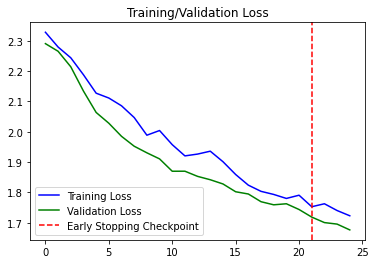

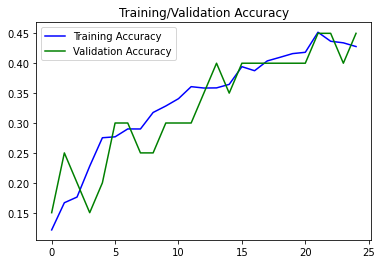

In [34]:
train_model(GD_model, train_iterator, valid_iterator, GD_optim, 
            loss_function, device, 'model_01/GD.pth', patience, EPOCHS)

In [35]:
test_loss, test_acc = evaluate(GD_model, test_iterator, loss_function, device)

In [36]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.749 | Test Acc: 45.00%


### Stochastic Gradient Descent Optimizer

**The below is a code but I omitted it because I saved the value**

max_count = 100
for count in range(max_count):
    reg = 10**random.uniform(-5,5)
    lr  = 10**random.uniform(-6,-3)
    
    SGD_model = MLP(n_classes)
    
    SGD_optim = optim.SGD(SGD_model.parameters(), lr=lr, weight_decay=reg)
    
    valid_acc_all = []
    
    for epoch in range(5):
    
        train_loss, train_acc = train(SGD_model, train_iterator_SGD, SGD_optim, loss_function , device)
        valid_loss, valid_acc = evaluate(SGD_model, valid_iterator_SGD, loss_function, device)
        
        valid_acc_all.append(valid_acc)
        
    
    val_acc = max(valid_acc_all)
    
    print(f"val_acc: {val_acc},\tlr: {lr},\treg: {reg},\t({count} / {max_count})")

#### Random search
After applying random search I got the best validation accuarcy is `40%`

`val_acc`: `0.4`,	`lr`: `4.1649262773715345e-05`,	`reg`: `23.630520626501458`


In [37]:
SGD_model = MLP(n_classes)

In [38]:
lr = 4.1649262773715345e-05
reg = 23.630520626501458
SGD_optim = optim.SGD(SGD_model.parameters(), lr=lr, weight_decay=reg)

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 0.039 | Train Acc: 0.15%
	 Val. Loss: 2.306 |  Val. Acc: 0.00%
EarlyStopping counter: 1 out of 15
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.038 | Train Acc: 0.18%
	 Val. Loss: 2.308 |  Val. Acc: 0.00%
EarlyStopping counter: 2 out of 15
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.039 | Train Acc: 0.16%
	 Val. Loss: 2.311 |  Val. Acc: 0.00%
EarlyStopping counter: 3 out of 15
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.039 | Train Acc: 0.15%
	 Val. Loss: 2.314 |  Val. Acc: 0.00%
EarlyStopping counter: 4 out of 15
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.038 | Train Acc: 0.20%
	 Val. Loss: 2.316 |  Val. Acc: 5.00%
Validation accuarcy increased (inf --> 0.050).  Saving model ...
Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.038 | Train Acc: 0.18%
	 Val. Loss: 2.316 |  Val. Acc: 10.00%
Validation accuarcy increased (inf --> 0.100).  Saving model ...
Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 0.038 | Train Acc: 0.18%
	 Val. Loss: 2.313 |  Val

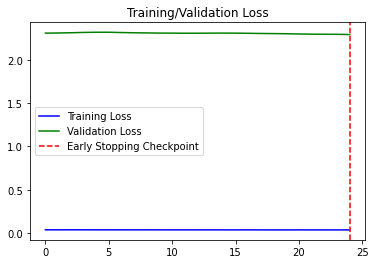

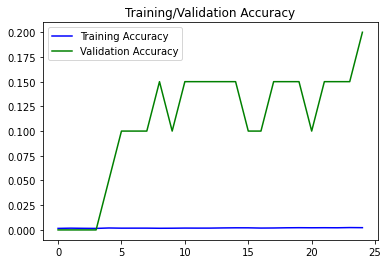

In [39]:
train_model(SGD_model, train_iterator_SGD, valid_iterator_SGD, SGD_optim,
            loss_function, device, 'model_01/SGD.pth', patience, EPOCHS)

In [40]:
test_loss, test_acc = evaluate(SGD_model, test_iterator_SGD, loss_function, device)

In [41]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 2.296 | Test Acc: 15.00%


### AdaGrad Optimizer

**The below is a code but I omitted it because I saved the value**

max_count = 30
for count in range(max_count):
    reg = 10**random.uniform(-5,5)
    lr  = 10**random.uniform(-6,-3)
    
    ADA_model = MLP(n_classes)
    
    ADA_optim = optim.Adagrad(ADA_model.parameters(), lr=lr, weight_decay=reg)
        
    valid_acc_all = []
    
    for epoch in range(5):
    
        train_loss, train_acc = train(ADA_model, train_iterator, ADA_optim, loss_function , device)
        valid_loss, valid_acc = evaluate(ADA_model, valid_iterator, loss_function, device)
        
        valid_acc_all.append(valid_acc)
        
    
    val_acc = max(valid_acc_all)
    
    print(f"val_acc: {val_acc},\tlr: {lr},\treg: {reg},\t({count} / {max_count})")

#### Random search
After applying random search I got two best validation accuarcy is `40%`

`val_acc`: `0.4000000059604645`,	`lr`: `0.00044581310357053586`,	`reg`: `1.3123452460554417` \\\
`val_acc`: `0.4000000059604645`,	`lr`: `0.000475278235522638`,	`reg`: `8.936468613304582`

In [42]:
ADA_model = MLP(n_classes)

In [43]:
lr = np.average(np.array([0.00044581310357053586, 0.000475278235522638]))
reg = np.average(np.array([1.3123452460554417, 8.936468613304582]))
Ada_optim = optim.Adagrad(ADA_model.parameters(), lr=lr, weight_decay=reg)

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 2.269 | Train Acc: 17.76%
	 Val. Loss: 2.288 |  Val. Acc: 25.00%
Validation accuarcy increased (inf --> 0.250).  Saving model ...
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 2.122 | Train Acc: 27.34%
	 Val. Loss: 2.255 |  Val. Acc: 30.00%
Validation accuarcy increased (inf --> 0.300).  Saving model ...
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 2.048 | Train Acc: 32.97%
	 Val. Loss: 2.205 |  Val. Acc: 40.00%
Validation accuarcy increased (inf --> 0.400).  Saving model ...
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 2.018 | Train Acc: 33.45%
	 Val. Loss: 2.141 |  Val. Acc: 35.00%
EarlyStopping counter: 1 out of 15
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 1.940 | Train Acc: 37.11%
	 Val. Loss: 2.023 |  Val. Acc: 35.00%
EarlyStopping counter: 2 out of 15
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 1.949 | Train Acc: 36.82%
	 Val. Loss: 1.914 |  Val. Acc: 40.00%
EarlyStopping counter: 3 out of 15
Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 1.913 | T

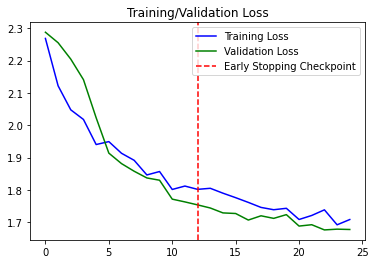

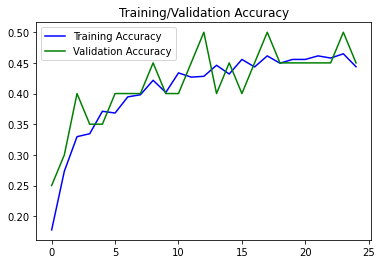

In [44]:
train_model(ADA_model, train_iterator, valid_iterator, Ada_optim,
            loss_function, device, 'model_01/AdaGrad.pth', patience, EPOCHS)

In [45]:
test_loss, test_acc = evaluate(ADA_model, test_iterator, loss_function, device)

In [46]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.651 | Test Acc: 55.00%


### RMSProp Optimizer

**The below is a code but I omitted it because I saved the value**

max_count = 100
for count in range(max_count):
    reg = 10**random.uniform(-5,5)
    lr  = 10**random.uniform(-6,-3)
    
    RMS_model = MLP(n_classes)
    
    RMS_optim = optim.RMSprop(RMS_model.parameters(), lr=lr, weight_decay=reg)
    
    valid_acc_all = []
    
    for epoch in range(5):
    
        train_loss, train_acc = train(RMS_model, train_iterator, RMS_optim, loss_function , device)
        valid_loss, valid_acc = evaluate(RMS_model, valid_iterator, loss_function, device)
        
        valid_acc_all.append(valid_acc)
        
    
    val_acc = max(valid_acc_all)
    
    print(f"val_acc: {val_acc},\tlr: {lr},\treg: {reg},\t({count} / {max_count})")

#### Random search
After applying random search I got the best validation accuarcy is `60%`

`val_acc`: `0.6000000238418579`,	`lr`: `0.0001001692546114079`,	`reg`: `0.00197610260009179`


In [47]:
RMS_model = MLP(n_classes)

In [48]:
lr = 0.0001001692546114079
reg = 0.00197610260009179
RMS_optim = optim.RMSprop(RMS_model.parameters(), lr=lr, weight_decay=reg)

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 2.360 | Train Acc: 10.66%
	 Val. Loss: 2.307 |  Val. Acc: 0.00%
EarlyStopping counter: 1 out of 15
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 2.355 | Train Acc: 10.56%
	 Val. Loss: 2.307 |  Val. Acc: 5.00%
Validation accuarcy increased (inf --> 0.050).  Saving model ...
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 2.358 | Train Acc: 10.22%
	 Val. Loss: 2.311 |  Val. Acc: 5.00%
EarlyStopping counter: 1 out of 15
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 2.367 | Train Acc: 9.71%
	 Val. Loss: 2.317 |  Val. Acc: 5.00%
EarlyStopping counter: 2 out of 15
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 2.354 | Train Acc: 9.84%
	 Val. Loss: 2.328 |  Val. Acc: 5.00%
EarlyStopping counter: 3 out of 15
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 2.370 | Train Acc: 9.22%
	 Val. Loss: 2.337 |  Val. Acc: 5.00%
EarlyStopping counter: 4 out of 15
Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 2.370 | Train Acc: 9.59%
	 Val. Loss: 2.340 |  Val. Acc: 5.00%
EarlyStopping c

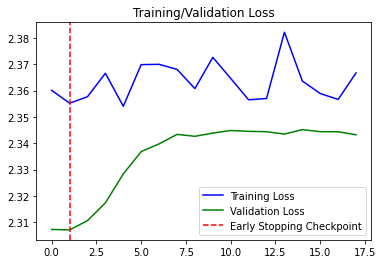

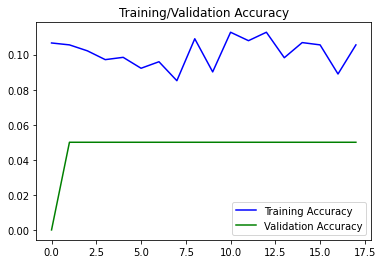

In [49]:
train_model(RMS_model, train_iterator, valid_iterator, Ada_optim,
            loss_function, device, 'model_01/RMSProp.pth', patience, EPOCHS)

In [50]:
test_loss, test_acc = evaluate(ADA_model, test_iterator, loss_function, device)

In [51]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 2.271 | Test Acc: 20.00%


### Adam Optimizer

max_count = 100
for count in range(max_count):
    reg = 10**random.uniform(-5,5)
    lr  = 10**random.uniform(-6,-3)
    
    ADM_model = MLP(n_classes)
    
    ADM_optim = optim.Adam(ADM_model.parameters(), lr=lr, weight_decay=reg)
    
    valid_acc_all = []
    
    for epoch in range(5):
    
        train_loss, train_acc = train(ADM_model, train_iterator, ADM_optim, loss_function , device)
        valid_loss, valid_acc = evaluate(ADM_model, valid_iterator, loss_function, device)
        
        valid_acc_all.append(valid_acc)
        
    
    val_acc = max(valid_acc_all)
    
    print(f"val_acc: {val_acc},\tlr: {lr},\treg: {reg},\t({count} / {max_count})")

#### Random search
After applying random search I got the best validation accuarcy is `55%`

`val_acc`: `0.550000011920929`,	`lr`: `0.0009616917613079441`,	`reg`: `0.006701303619234062` \\\
`val_acc`: `0.550000011920929`,	`lr`: `0.00011481223213096693`,	`reg`: `2.2342074783747663e-05`



In [52]:
ADAM_model = MLP(n_classes)

In [53]:
lr  = 0.00011481223213096693
reg = 2.2342074783747663e-05
Adm_optim = optim.Adam(ADAM_model.parameters(), lr=lr, weight_decay=reg)

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 2.345 | Train Acc: 12.35%
	 Val. Loss: 2.295 |  Val. Acc: 25.00%
Validation accuarcy increased (inf --> 0.250).  Saving model ...
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 2.341 | Train Acc: 10.31%
	 Val. Loss: 2.291 |  Val. Acc: 15.00%
EarlyStopping counter: 1 out of 15
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 2.314 | Train Acc: 12.59%
	 Val. Loss: 2.283 |  Val. Acc: 20.00%
EarlyStopping counter: 2 out of 15
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 2.337 | Train Acc: 10.17%
	 Val. Loss: 2.272 |  Val. Acc: 15.00%
EarlyStopping counter: 3 out of 15
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 2.361 | Train Acc: 10.75%
	 Val. Loss: 2.264 |  Val. Acc: 15.00%
EarlyStopping counter: 4 out of 15
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 2.365 | Train Acc: 9.70%
	 Val. Loss: 2.264 |  Val. Acc: 15.00%
EarlyStopping counter: 5 out of 15
Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 2.356 | Train Acc: 11.51%
	 Val. Loss: 2.262 |  Val. Acc: 15.00%
Early

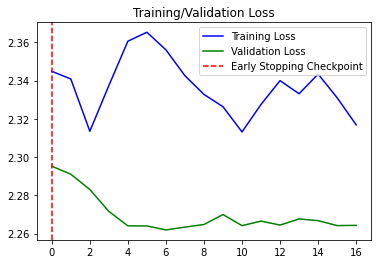

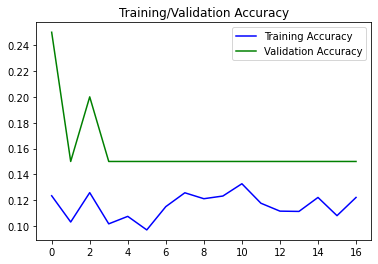

In [54]:
train_model(ADAM_model, train_iterator, valid_iterator, Ada_optim,
            loss_function, device, 'model_01/Adam.pth', patience, EPOCHS)

In [55]:
test_loss, test_acc = evaluate(ADAM_model, test_iterator, loss_function, device)

In [56]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 2.290 | Test Acc: 15.00%


## Change Network architecture

In [57]:
class MLP2(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, padding = 1)                   
        self.conv2 = nn.Conv2d(32, 16, kernel_size=7, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        

        self.conv3 = nn.Conv2d(16, 32, kernel_size=5, padding = 1)
        

        self.drop = nn.Dropout2d(0.5)

        self.conv4 = nn.Conv2d(32, 16, kernel_size=5, padding = 1)
        
        
        self.batch = nn.BatchNorm2d(16)

        self.fc = nn.Linear(9216, n_classes)
        
        
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.drop(x)
        x = F.relu(self.conv4(x))
        x = self.batch(x)
        
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc(x))
        
        
        return x

In [58]:
model = MLP2(n_classes)
model.get_parameter

<bound method Module.get_parameter of MLP2(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (drop): Dropout2d(p=0.5, inplace=False)
  (conv4): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (batch): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=9216, out_features=10, bias=True)
)>

In [59]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 147,690 trainable parameters


### Gradient Descent Optimizer 2

**The below is a code but I omitted it because I saved the value**

max_count = 100
for count in range(max_count):
    reg = 10**random.uniform(-5,5)
    lr  = 10**random.uniform(-6,-3)
    
    GD_model = MLP2(n_classes)
    
    GD_optim = optim.SGD(GD_model.parameters(), lr=lr, weight_decay=reg)
    

    valid_acc_all = []

    
    for epoch in range(5):
    
        train_loss, train_acc = train(GD_model, train_iterator, GD_optim, loss_function , device)
        valid_loss, valid_acc = evaluate(GD_model, valid_iterator, loss_function, device)
        
        valid_acc_all.append(valid_acc)
        
    
    val_acc = max(valid_acc_all)
    
    print(f"val_acc: {val_acc},\tlr: {lr},\treg: {reg},\t({count} / {max_count})")

#### Random search
After applying random search I got the best validation accuarcy is `35%`

`val_acc`: `0.3499999940395355`,	`lr`: `0.0006296340872198513`,	`reg`: `10.038361680178536`\\\
`val_acc`: `0.3499999940395355`,	`lr`: `0.0004333758904199467`,	`reg`: `3.155482806259666e-05`\\\
`val_acc`: `0.3499999940395355`,	`lr`: `0.00046186066914828303`,	`reg`: `5.602119121925794`\\\
`val_acc`: `0.3499999940395355`,	`lr`: `6.632022217874901e-06`,	`reg`: `0.00931901219670067`



In [60]:
GD_model = MLP2(n_classes)

In [61]:
lr = np.average(np.array([0.0006296340872198513, 0.0004333758904199467, 0.00046186066914828303, 6.632022217874901e-06]))
reg = np.average(np.array([10.038361680178536, 3.155482806259666e-05, 5.602119121925794, 0.00931901219670067]))
GD_optim = optim.SGD(GD_model.parameters(), lr=lr, weight_decay=reg)

Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 2.337 | Train Acc: 11.35%
	 Val. Loss: 2.298 |  Val. Acc: 20.00%
Validation accuarcy increased (inf --> 0.200).  Saving model ...
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 2.296 | Train Acc: 14.94%
	 Val. Loss: 2.291 |  Val. Acc: 25.00%
Validation accuarcy increased (inf --> 0.250).  Saving model ...
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 2.274 | Train Acc: 16.19%
	 Val. Loss: 2.281 |  Val. Acc: 30.00%
Validation accuarcy increased (inf --> 0.300).  Saving model ...
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 2.263 | Train Acc: 16.76%
	 Val. Loss: 2.253 |  Val. Acc: 35.00%
Validation accuarcy increased (inf --> 0.350).  Saving model ...
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 2.234 | Train Acc: 19.29%
	 Val. Loss: 2.207 |  Val. Acc: 35.00%
EarlyStopping counter: 1 out of 15
Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 2.202 | Train Acc: 21.82%
	 Val. Loss: 2.159 |  Val. Acc: 35.00%
EarlyStopping counter: 2 out of 15
Epoch: 07 | Epoch Time

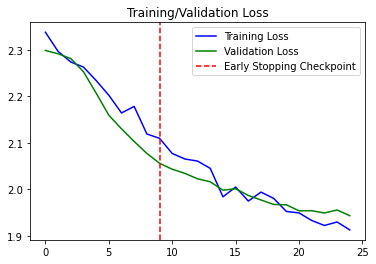

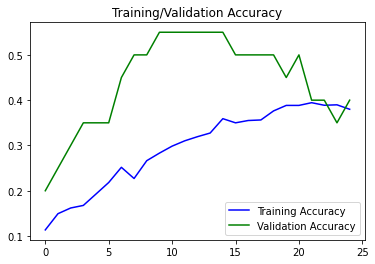

In [62]:
train_model(GD_model, train_iterator, valid_iterator, GD_optim,
            loss_function, device, 'model_02/GD.pth', patience, EPOCHS)

In [63]:
test_loss, test_acc = evaluate(GD_model, test_iterator, loss_function, device)

In [64]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.959 | Test Acc: 40.00%


### Stochastic Gradient Descent Optimizer 2

**The below is a code but I omitted it because I saved the value**

max_count = 30
for count in range(max_count):
    reg = 10**random.uniform(-5,5)
    lr  = 10**random.uniform(-6,-3)
    
    SGD_model = MLP2(n_classes)
    
    SGD_optim = optim.SGD(SGD_model.parameters(), lr=lr, weight_decay=reg)
    
    valid_acc_all = []
    
    for epoch in range(5):
    
        train_loss, train_acc = train(SGD_model, train_iterator_SGD, SGD_optim, loss_function , device)
        valid_loss, valid_acc = evaluate(SGD_model, valid_iterator_SGD, loss_function, device)
        
        valid_acc_all.append(valid_acc)
        
    
    val_acc = max(valid_acc_all)
    
    print(f"val_acc: {val_acc},\tlr: {lr},\treg: {reg},\t({count} / {max_count})")

#### Random search
After applying random search I got the best validation accuarcy is `50%`

`val_acc`: `0.5`,	`lr`: `0.0006513520125666456`,	`reg`: `0.08310862923933089`\\\
`val_acc`: `0.5`,	`lr`: `0.00020033677808127466`,	`reg`: `0.007835813909088416`




In [65]:
SGD_model = MLP2(n_classes)

In [66]:
lr  = 0.0006513520125666456
reg = 0.08310862923933089
SGD_optim = optim.SGD(SGD_model.parameters(), lr=lr, weight_decay=reg)

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.038 | Train Acc: 0.20%
	 Val. Loss: 2.295 |  Val. Acc: 30.00%
Validation accuarcy increased (inf --> 0.300).  Saving model ...
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.037 | Train Acc: 0.30%
	 Val. Loss: 2.273 |  Val. Acc: 45.00%
Validation accuarcy increased (inf --> 0.450).  Saving model ...
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.036 | Train Acc: 0.37%
	 Val. Loss: 2.232 |  Val. Acc: 40.00%
EarlyStopping counter: 1 out of 15
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.035 | Train Acc: 0.41%
	 Val. Loss: 2.154 |  Val. Acc: 35.00%
EarlyStopping counter: 2 out of 15
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.034 | Train Acc: 0.48%
	 Val. Loss: 2.053 |  Val. Acc: 40.00%
EarlyStopping counter: 3 out of 15
Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.034 | Train Acc: 0.49%
	 Val. Loss: 2.006 |  Val. Acc: 40.00%
EarlyStopping counter: 4 out of 15
Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.033 | Train Acc: 0.58%
	 Val. Loss: 1.946 |

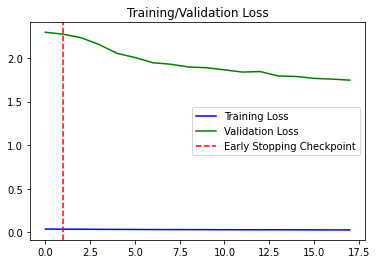

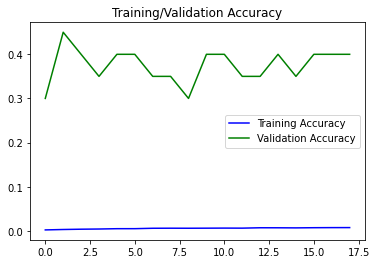

In [67]:
train_model(SGD_model, train_iterator_SGD, valid_iterator_SGD, SGD_optim,
            loss_function, device, 'model_02/SGD.pth', patience, EPOCHS)

In [68]:
test_loss, test_acc = evaluate(SGD_model, test_iterator_SGD, loss_function, device)

In [69]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.705 | Test Acc: 40.00%


### AdaGrad Optimizer 2

**The below is a code but I omitted it because I saved the value**

max_count = 20
for count in range(max_count):
    reg = 10**random.uniform(-5,5)
    lr  = 10**random.uniform(-6,-3)
    
    ADA_model = MLP2(n_classes)
    
    ADA_optim = optim.Adagrad(ADA_model.parameters(), lr=lr, weight_decay=reg)
    
    valid_acc_all = []
    
    for epoch in range(5):
    
        train_loss, train_acc = train(ADA_model, train_iterator, ADA_optim, loss_function , device)
        valid_loss, valid_acc = evaluate(ADA_model, valid_iterator, loss_function, device)
        
        valid_acc_all.append(valid_acc)
        
    
    val_acc = max(valid_acc_all)
    
    print(f"val_acc: {val_acc},\tlr: {lr},\treg: {reg},\t({count} / {max_count})")

#### Random search
After applying random search I got two best validation accuarcy is `40%`

`val_acc`: `0.4000000059604645`,	`lr`: `6.112081318877556e-06`,	`reg`: `1.5235536681941197`



In [70]:
ADA_model = MLP2(n_classes)

In [71]:
lr = 0.0005564185437939043
reg = 14.4128386710852
Ada_optim = optim.Adagrad(ADA_model.parameters(), lr=lr, weight_decay=reg)

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 2.232 | Train Acc: 18.91%
	 Val. Loss: 2.287 |  Val. Acc: 25.00%
Validation accuarcy increased (inf --> 0.250).  Saving model ...
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 2.133 | Train Acc: 29.94%
	 Val. Loss: 2.273 |  Val. Acc: 30.00%
Validation accuarcy increased (inf --> 0.300).  Saving model ...
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 2.075 | Train Acc: 28.91%
	 Val. Loss: 2.261 |  Val. Acc: 35.00%
Validation accuarcy increased (inf --> 0.350).  Saving model ...
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 2.036 | Train Acc: 36.58%
	 Val. Loss: 2.225 |  Val. Acc: 30.00%
EarlyStopping counter: 1 out of 15
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 1.998 | Train Acc: 37.65%
	 Val. Loss: 2.162 |  Val. Acc: 30.00%
EarlyStopping counter: 2 out of 15
Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 1.982 | Train Acc: 37.66%
	 Val. Loss: 2.067 |  Val. Acc: 40.00%
Validation accuarcy increased (inf --> 0.400).  Saving model ...
Epoch: 07 | Epoch Time

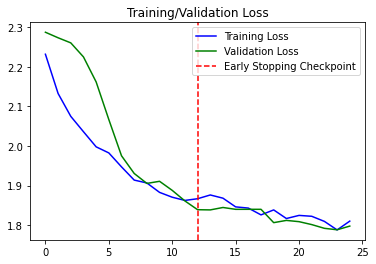

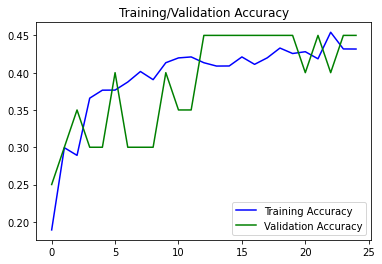

In [72]:
train_model(ADA_model, train_iterator, valid_iterator, Ada_optim,
            loss_function, device, 'model_02/AdaGrad.pth', patience, EPOCHS)

In [73]:
test_loss, test_acc = evaluate(ADA_model, test_iterator, loss_function, device)

In [74]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.707 | Test Acc: 55.00%


### RMSProp Optimizer 2

**The below is a code but I omitted it because I saved the value**

max_count = 30
for count in range(max_count):
    reg = 10**random.uniform(-5,5)
    lr  = 10**random.uniform(-6,-3)
    
    RMS_model = MLP2(n_classes)
    
    RMS_optim = optim.RMSprop(RMS_model.parameters(), lr=lr, weight_decay=reg)
    

    
    valid_acc_all = []
    
    for epoch in range(5):
    
        train_loss, train_acc = train(RMS_model, train_iterator, RMS_optim, loss_function , device)
        valid_loss, valid_acc = evaluate(RMS_model, valid_iterator, loss_function, device)
        
        valid_acc_all.append(valid_acc)
        
    
    val_acc = max(valid_acc_all)
    
    print(f"val_acc: {val_acc},\tlr: {lr},\treg: {reg},\t({count} / {max_count})")

#### Random search
After applying random search I got the best validation accuarcy is `55%`

`val_acc`: `0.550000011920929`,	`lr`: `0.00012238078716947105`,	`reg`: `0.0006739542483213087`

In [75]:
RMS_model = MLP2(n_classes)

In [76]:
lr = 0.0001017833159861788
reg = 6.528654364863553e-05
RMS_optim = optim.RMSprop(RMS_model.parameters(), lr=lr, weight_decay=reg)

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 2.359 | Train Acc: 10.69%
	 Val. Loss: 2.302 |  Val. Acc: 20.00%
Validation accuarcy increased (inf --> 0.200).  Saving model ...
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 2.375 | Train Acc: 7.19%
	 Val. Loss: 2.299 |  Val. Acc: 20.00%
EarlyStopping counter: 1 out of 15
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 2.338 | Train Acc: 10.54%
	 Val. Loss: 2.297 |  Val. Acc: 20.00%
EarlyStopping counter: 2 out of 15
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 2.351 | Train Acc: 9.74%
	 Val. Loss: 2.294 |  Val. Acc: 20.00%
EarlyStopping counter: 3 out of 15
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 2.388 | Train Acc: 8.27%
	 Val. Loss: 2.295 |  Val. Acc: 20.00%
EarlyStopping counter: 4 out of 15
Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 2.350 | Train Acc: 12.47%
	 Val. Loss: 2.300 |  Val. Acc: 15.00%
EarlyStopping counter: 5 out of 15
Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 2.341 | Train Acc: 11.95%
	 Val. Loss: 2.304 |  Val. Acc: 15.00%
EarlySt

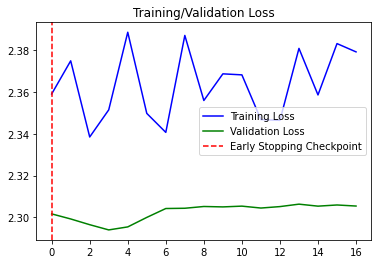

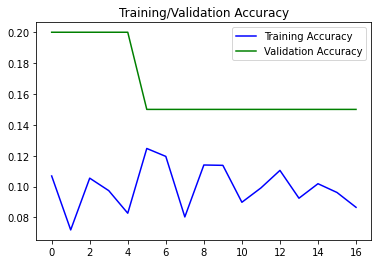

In [77]:
train_model(RMS_model, train_iterator, valid_iterator, Ada_optim, 
            loss_function, device, 'model_02/RMSProp.pth', patience, EPOCHS)

In [78]:
test_loss, test_acc = evaluate(ADA_model, test_iterator, loss_function, device)

In [79]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 2.301 | Test Acc: 10.00%


### Adam Optimizer 2

max_count = 16
for count in range(max_count):
    reg = 10**random.uniform(-5,5)
    lr  = 10**random.uniform(-6,-3)
    
    ADM_model = MLP2(n_classes)
    
    ADM_optim = optim.Adam(ADM_model.parameters(), lr=lr, weight_decay=reg)

    
    valid_acc_all = []
    
    for epoch in range(5):
    
        train_loss, train_acc = train(ADM_model, train_iterator, ADM_optim, loss_function , device)
        valid_loss, valid_acc = evaluate(ADM_model, valid_iterator, loss_function, device)
        
        valid_acc_all.append(valid_acc)
        
    
    val_acc = max(valid_acc_all)
    
    print(f"val_acc: {val_acc},\tlr: {lr},\treg: {reg},\t({count} / {max_count})")

#### Random search
After applying random search I got the best validation accuarcy is `60%`

`val_acc`: `0.6000000238418579`,	`lr`: `0.000670608896324397`,	`reg`: `0.00016303525443355378`




In [80]:
ADAM_model = MLP2(n_classes)

In [81]:
lr = 0.000670608896324397
reg = 0.00016303525443355378
Adm_optim = optim.Adam(ADAM_model.parameters(), lr=lr, weight_decay=reg)

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 2.255 | Train Acc: 21.07%
	 Val. Loss: 2.202 |  Val. Acc: 35.00%
Validation accuarcy increased (inf --> 0.350).  Saving model ...
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 2.047 | Train Acc: 31.49%
	 Val. Loss: 1.992 |  Val. Acc: 25.00%
EarlyStopping counter: 1 out of 15
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 1.995 | Train Acc: 33.57%
	 Val. Loss: 1.714 |  Val. Acc: 40.00%
Validation accuarcy increased (inf --> 0.400).  Saving model ...
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 1.805 | Train Acc: 41.48%
	 Val. Loss: 1.486 |  Val. Acc: 50.00%
Validation accuarcy increased (inf --> 0.500).  Saving model ...
Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 1.784 | Train Acc: 40.89%
	 Val. Loss: 1.499 |  Val. Acc: 50.00%
EarlyStopping counter: 1 out of 15
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 1.756 | Train Acc: 43.33%
	 Val. Loss: 1.569 |  Val. Acc: 40.00%
EarlyStopping counter: 2 out of 15
Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 1.668 | T

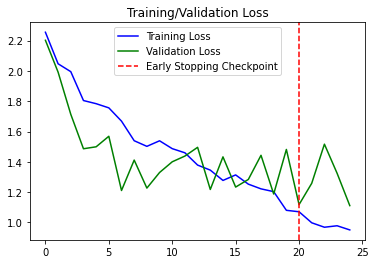

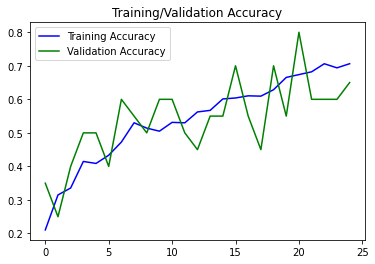

In [82]:
train_model(ADAM_model, train_iterator, valid_iterator, Adm_optim,
            loss_function, device, 'model_02/Adam.pth', patience, EPOCHS)

In [83]:
test_loss, test_acc = evaluate(ADAM_model, test_iterator, loss_function, device)

In [84]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.846 | Test Acc: 70.00%


## Transfer Learning

In [33]:
# Loading the model
vgg16_model =  torchvision.models.vgg16(pretrained=True)

In [34]:
#freezing the 
for param in vgg16_model.parameters():
    param.requires_grad = False

In [54]:
# New classifier to replace the old one
classifier = nn.Sequential(*[
    vgg16_model.classifier[0],                   # Keeping the first FC
    vgg16_model.classifier[1],                   # Keeping its activation function
    nn.Linear(in_features=4096, out_features=n_classes, bias=True)    # new classiefer to output the number of classes
])

In [57]:
# replacing the classifier
vgg16_model.classifier = classifier 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [88]:
# Editing the classifier with the number of classes used
vgg16_model.classifier = nn.Sequential(*[
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=n_classes, bias=True)
])
# freeze the first two again without the last one
vgg16_model.classifier[0].requires_grad_uires_grad_ = False
vgg16_model.classifier[1].requires_grad_uires_grad_ = False

In [89]:
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch: 01 | Epoch Time: 0m 35s
	Train Loss: 20.124 | Train Acc: 24.34%
	 Val. Loss: 31.848 |  Val. Acc: 20.00%
Validation accuarcy increased (inf --> 0.200).  Saving model ...
Epoch: 02 | Epoch Time: 0m 33s
	Train Loss: 11.748 | Train Acc: 39.88%
	 Val. Loss: 9.433 |  Val. Acc: 25.00%
Validation accuarcy increased (inf --> 0.250).  Saving model ...
Epoch: 03 | Epoch Time: 0m 33s
	Train Loss: 11.699 | Train Acc: 40.02%
	 Val. Loss: 18.854 |  Val. Acc: 30.00%
Validation accuarcy increased (inf --> 0.300).  Saving model ...
Epoch: 04 | Epoch Time: 0m 33s
	Train Loss: 7.027 | Train Acc: 50.61%
	 Val. Loss: 13.702 |  Val. Acc: 30.00%
EarlyStopping counter: 1 out of 5
Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 8.232 | Train Acc: 49.07%
	 Val. Loss: 11.149 |  Val. Acc: 25.00%
EarlyStopping counter: 2 out of 5
Epoch: 06 | Epoch Time: 0m 33s
	Train Loss: 7.449 | Train Acc: 47.96%
	 Val. Loss: 6.615 |  Val. Acc: 45.00%
Validation accuarcy increased (inf --> 0.450).  Saving model ...
Epoch: 07 |

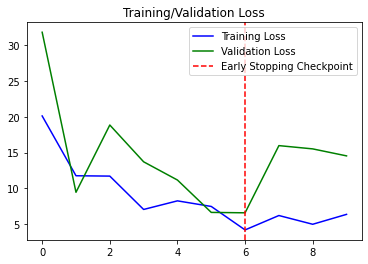

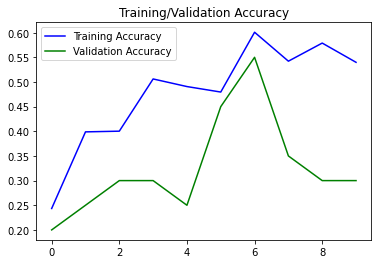

In [58]:
optimizer_conv = optim.SGD(vgg16_model.classifier.parameters(), lr=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

EPOCHS   = 10    # Number of Epochs 
patience = 5     # Number of patience values for EarlyStopping

train_model(vgg16_model, train_iterator, valid_iterator, optimizer_conv, loss_function,
            device, 'transfer_learning/vgg16.pth', patience, EPOCHS)

In [59]:
test_loss, test_acc = evaluate(vgg16_model, test_iterator, loss_function, device)

In [60]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 13.372 | Test Acc: 55.00%


## Refrences

* **11_01_Multilayer_Perceptron.ipynb** - From course content in the Blackboard 
* **TRAINING A CLASSIFIER** - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* **TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL** - https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* **early-stopping-pytorch** - https://github.com/Bjarten/early-stopping-pytorch
* **Image classification with PyTorch tutorials** - https://youtube.com/playlist?list=PL3Dh_99BJkCEhE7Ri8W6aijiEqm3ZoGRq
* **PyTorch: Gradient Descent, Stochastic Gradient Descent and Mini Batch Gradient Descent** - https://www.linkedin.com/pulse/pytorch-gradient-descent-stochastic-mini-batch-code-sobh-phd/
* **TORCHVISION.TRANSFORMS** - https://pytorch.org/vision/stable/transforms.html#
* **TORCH.OPTIM** - https://pytorch.org/docs/stable/optim.html